In [1]:
import pandas as pd
from config import BASE_DIR
import numpy as np
from src.baselines.utils import create_adjacency_matrix

In [2]:
exp_dir = f"{BASE_DIR}/experiments/sectarian_similarities"
df_name = "filtered_df_CHUNK_SIZE=100_MAX_OVERLAP=15_PRE_PROCESSING_TASKS=[]_2024_28_08"
df = pd.read_csv(f"{BASE_DIR}/data/processed_data/{df_name}.csv")

In [3]:
from src.baselines.embeddings import  VectorizerProcessor
from src.constants import BERT_MODELS
vectorizers = BERT_MODELS + ["trigram", "tfidf", "starr"]

processor = VectorizerProcessor(df, f"{exp_dir}/{df_name}.pkl", vectorizers)
processed_vectorizers = processor.load_or_generate_embeddings()

adjacency_matrix_all = create_adjacency_matrix(
    df,
    context_similiarity_window=3,
    composition_level=False,
)

Loaded the embeddings: ['yonatanlou/BEREL-finetuned-DSS-maskedLM', 'dicta-il/dictabert', 'starr', 'trigram', 'onlplab/alephbert-base', 'dicta-il/BEREL', 'tfidf']
Loaded the following embeddings dict_keys(['yonatanlou/BEREL-finetuned-DSS-maskedLM', 'dicta-il/dictabert', 'starr', 'trigram', 'onlplab/alephbert-base', 'dicta-il/BEREL', 'tfidf'])


Building adjacency matrix: 100%|██████████| 1238/1238 [00:01<00:00, 1009.68it/s]


### Add labels
For matching each chunk to it label, the main issue in in the edge cases, where the chunk have 2 labels.
Im assigning the label the majority of the chunk is in.

In [4]:
# Define your labels with their corresponding ranges
labels_1QS = {
    "1QS=1:1 – 3:12": (1, 1, 3, 12),
    "1QS=3:13 – 4:26": (3, 13, 4, 26),
    "1QS=5:1 – 6:23": (5, 1, 6, 23),
    "1QS=6:24 – 7:25": (6, 24, 7, 25),
    "1QS=8:1 – 8:19": (8, 1, 8, 19),
    "1QS=8:20 – 9:11": (8, 20, 9, 11),
    "1QS=9:12 – 9:26": (9, 12, 9, 26),
    "1QS=10:1 – 11:22": (10, 1, 11, 22),
    "1QSa=all": (1000,1000,1000,1000)  
}

labels_hodayot = {
    "1QHa=3:1 – 8:28": (3, 1, 8, 28),
    "1QHa=9:1 – 10:19": (9, 1, 10, 19),
    "1QHa=10:20 – 17:36": (10, 20, 17, 36),
    "1QHa=17:38 – 23:16": (17, 38, 23, 16),
    "1QHa=allTheRest": (23,16,1,1)
    
}

labels_1QM = {
    "1QM=1:1 – 1:18": (1, 1, 1, 18),
    "1QM=allTheRest": (2, 1, 10000, 1000),
    
}



def parse_range(sentence_path):
    start, end = sentence_path.split('-')
    scroll = start.split(":")[0]
    
    start = start.split(":")[1:]
    start_chapter, start_verse = map(int, start)
    
    end_chapter, end_verse = map(int, end.split(':'))
    return scroll, start_chapter, start_verse, end_chapter, end_verse


def calculate_overlap(start_chapter, start_verse, end_chapter, end_verse, l_start_chapter, l_start_verse, l_end_chapter, l_end_verse):
    # Convert the start and end points to a comparable single number (e.g., verse count)
    start = start_chapter * 1000 + start_verse
    end = end_chapter * 1000 + end_verse
    l_start = l_start_chapter * 1000 + l_start_verse
    l_end = l_end_chapter * 1000 + l_end_verse

    # Calculate overlap
    overlap_start = max(start, l_start)
    overlap_end = min(end, l_end)
    overlap = max(0, overlap_end - overlap_start)
    return overlap

def match_label(sentence_path, labels):
    scroll, start_chapter, start_verse, end_chapter, end_verse = parse_range(sentence_path)
    if scroll == "1QSa":
        return "1QSa"


    max_overlap = 0
    best_label = None

    for label, (l_start_chapter, l_start_verse, l_end_chapter, l_end_verse) in labels.items():
        if label.startswith(scroll):  # Ensure we are matching the correct scroll
            overlap = calculate_overlap(start_chapter, start_verse, end_chapter, end_verse, l_start_chapter, l_start_verse, l_end_chapter, l_end_verse)
            if overlap > max_overlap:
                max_overlap = overlap
                best_label = label
    if not best_label:
        best_label = [lab for lab in labels.keys() if "allTheRest" in lab][0]
    return best_label

def label_sentence_path(df_labeled_for_clustering, labels, verbose=True):
    sentence_paths = df_labeled_for_clustering["sentence_path"].to_list()
    results = []
    for sentence_path in sentence_paths:
        try:
            label = match_label(sentence_path, labels)
        except:
            label = [lab for lab in labels.keys() if "allTheRest" in lab][0]
        results.append((sentence_path, label))
        if verbose:
            print(f"Sentence Path: {sentence_path} -> Label: {label}")
    
    df_labeled_for_clustering = df_labeled_for_clustering.copy()
    df_labeled_for_clustering.loc[:, "label"] = [i[1] for i in results]
    # df_labeled_for_clustering["label"] = [i[1] for i in results]
    return df_labeled_for_clustering


# curr_scroll = ["1QM"]
# df_labeled_for_clustering = df[df["book"].isin(curr_scroll)]
# df_labeled_for_clustering = label_sentence_path(df_labeled_for_clustering, labels_1QM,verbose=True)

## Functions

In [5]:

import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage,fcluster
from sknetwork.hierarchy import dasgupta_score as calculate_dasgupta_score
from sklearn.metrics import adjusted_rand_score, jaccard_score, rand_score
from sklearn.preprocessing import LabelEncoder
import scipy
def round_metrics(metrics, n=3):
    new_metrics={}
    for k,v in metrics.items():
        new_metrics[k] = np.round(v,3)
    return new_metrics

def cluster_and_get_metrics(df_labeled_for_clustering,embeddings_tmp,adjacency_matrix_tmp,linkage_m):
    n_clusters = len(df_labeled_for_clustering['label'].unique())
    linkage_matrix = linkage(embeddings_tmp, method=linkage_m)
    
    
    
    # Calculate Jaccard Index
    flat_clusters = fcluster(linkage_matrix, n_clusters, criterion='maxclust')
    le = LabelEncoder()
    true_labels_encoded = le.fit_transform(df_labeled_for_clustering['label'])
    
    jaccard = jaccard_score(true_labels_encoded, flat_clusters, average='weighted')
    ari = adjusted_rand_score(df_labeled_for_clustering['label'], flat_clusters)
    # ari = rand_score(df_labeled_for_clustering['label'], flat_clusters)
    dasgupta = calculate_dasgupta_score(adjacency_matrix_tmp, linkage_matrix)
    
    metrics = {"jaccard":jaccard, "dasgupta":dasgupta, "ari":ari}
    return linkage_matrix, metrics



def generate_dendrogram_plot(df_labeled_for_clustering, linkage_matrix, vec_type, metrics, curr_scroll, label_to_plot="sentence_path"):
    if label_to_plot not in ["sentence_path", "label"]:
        raise
    metrics = round_metrics(metrics)

    # Create a color map based on the 'label' column
    unique_labels = df_labeled_for_clustering['label'].unique()
    label_colors = plt.cm.copper(np.linspace(0, 1, len(unique_labels)))
    color_map = dict(zip(unique_labels, label_colors))
    
    # Plot the dendrogram
    plt.figure(figsize=(15, 10))  # Swap width and height for vertical orientation
    dendrogram(
        linkage_matrix,
        labels=df_labeled_for_clustering[label_to_plot].tolist(),
        orientation='left',  # This makes the dendrogram vertical
        leaf_font_size=6,
        leaf_rotation=0  # Horizontal text for better readability
    )
    plt.yticks(fontsize=10)
    
    plt.title(f'embeddings: {vec_type}, {metrics}')
    plt.ylabel('Sentence Path')  # Swap x and y labels
    plt.xlabel('Distance')
    plt.suptitle(f"{curr_scroll} scroll clustering")
    # Color the y-axis labels according to their labels
    ax = plt.gca()
    ylbls = ax.get_ymajorticklabels()
    for idx, lbl in enumerate(ylbls):
        if label_to_plot == "sentence_path":
            label = df_labeled_for_clustering[df_labeled_for_clustering["sentence_path"]==lbl.get_text()]["label"].values[0]
        else:
            label = lbl.get_text()
        lbl.set_color(color_map[label])
        lbl.set_text(label)
    
    # Add a legend
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=label, 
                       markerfacecolor=color, markersize=10)
                       for label, color in color_map.items()]
    plt.legend(handles=legend_elements, title='Labels', loc='best', bbox_to_anchor=(0, 1))
    
    plt.tight_layout()
    plt.show()

def hirerchial_clustering_by_scroll(df:pd.DataFrame, curr_scroll:list[str], labels:dict, vec_type:str, processed_vectorizers:dict,adjacency_matrix,label_to_plot, kwargs):
    linkage_m = kwargs["linkage_m"]
    #get labels
    df_labeled_for_clustering = df[df["book"].isin(curr_scroll)]
    df_labeled_for_clustering = label_sentence_path(df_labeled_for_clustering, labels,verbose=False)

    #get embeddings
    embeddings = processed_vectorizers[vec_type]
    label_idxs = list(df_labeled_for_clustering.index)
    adjacency_matrix_tmp = adjacency_matrix_all[label_idxs, :][
        :, label_idxs]
    embeddings_tmp = embeddings[label_idxs]
    if type(embeddings_tmp) == scipy.sparse._csr.csr_matrix:
        embeddings_tmp= embeddings_tmp.toarray()

    #get metrics and linkage
    linkage_matrix, metrics = cluster_and_get_metrics(df_labeled_for_clustering,embeddings_tmp,adjacency_matrix_tmp, linkage_m)

    #plot
    if label_to_plot:
        generate_dendrogram_plot(df_labeled_for_clustering, linkage_matrix, vec_type, metrics, curr_scroll,label_to_plot)
    return metrics



## P values
For constructing the p-values, im running hirerchial clustering 100 times, each time with 70% of the data.
In each itereation, im generaring random features.
Im generating 3 different metrics for each embedding type for each scroll (ari, dasgupta, jaccard).
For each metric, i can get p-value by asking for each scroll->embedding->metric is the metric is higher than the random features.
So i will get for each scroll, for each embedding, for each metric a p value.

In [6]:
from src.baselines.utils import set_seed_globally
from tqdm.notebook import tqdm
set_seed_globally(435)

all_scrolls_to_cluster = [["1QHa"],["1QS","1QSa"],["1QM"]]
all_labels = [labels_hodayot,labels_1QS, labels_1QM]
linkage_methods = ['ward']
ITERS = 100
FRAC = 0.7
all_res_for_p_vals = []
for curr_scroll, labels in tqdm(zip(all_scrolls_to_cluster, all_labels)):
    for _ in tqdm(range(ITERS)):
        df_tmp = df[df["book"].isin(curr_scroll)]
        df_tmp = df_tmp.sample(frac=FRAC)
        for vec_type in vectorizers + ["random"]:
            if vec_type == "random":
                processed_vectorizers["random"] = random_array = np.random.rand(1238, 1000)
            for linkage_tmp in linkage_methods:
                kwargs = {"linkage_m":linkage_tmp}
                tmp_metrics = hirerchial_clustering_by_scroll(df_tmp, curr_scroll, labels, vec_type, processed_vectorizers,adjacency_matrix_all, None, kwargs)
                tmp_metrics.update({"vectorizer":vec_type, "scroll":curr_scroll,"n_labels":len(labels)})
                tmp_metrics.update(kwargs)
                all_res_for_p_vals.append(tmp_metrics)



# linkage_methods = ['ward','complete', 'average', 'weighted', 'centroid', 'median' ]

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [7]:
import pandas as pd
from scipy.stats import mannwhitneyu

# Assuming results DataFrame is already created
results = pd.DataFrame(all_res_for_p_vals)
results["scroll"] = results["scroll"].astype(str)

# Initialize a list to store the results
p_values = []

# Loop through each unique scroll
for scroll in results['scroll'].unique():
    # Filter the results for the current scroll
    results_one_scroll = results[results['scroll'] == scroll]
    
    # Loop through each unique vectorizer
    for vectorizer in results_one_scroll['vectorizer'].unique():
        if vectorizer == "random":
            continue  # Skip the random vectorizer itself
        
        # Initialize a dictionary to store p-values for the current scroll and vectorizer
        p_value_dict = {'scroll': scroll, 'vectorizer': vectorizer}
        
        # Loop through each metric: 'jaccard', 'ari', 'dasgupta'
        for metric in ['jaccard', 'ari', 'dasgupta']:
            # Get the embeddings for the current vectorizer
            tmp_embedding = results_one_scroll[results_one_scroll['vectorizer'] == vectorizer][metric]
            random_embedding = results_one_scroll[results_one_scroll['vectorizer'] == "random"][metric]
            
            # Perform the Mann-Whitney U test
            u_stat, p_value = mannwhitneyu(tmp_embedding, random_embedding)
            
            # Store the p-value in the dictionary
            p_value_dict[f'{metric}_p_value'] = np.round(p_value,6)
        
        # Append the dictionary to the list
        p_values.append(p_value_dict)

# Convert the list to a DataFrame
p_values_df = pd.DataFrame(p_values)

# Display the results
p_values_df.sort_values(by=['scroll', 'vectorizer'], inplace=True)
p_values_df


,scroll,vectorizer,jaccard_p_value,ari_p_value,dasgupta_p_value
0,['1QHa'],dicta-il/BEREL,0.666280,0.000000,0.0
2,['1QHa'],dicta-il/dictabert,0.006561,0.000000,0.0
1,['1QHa'],onlplab/alephbert-base,0.627665,0.000000,0.0
6,['1QHa'],starr,0.005012,0.000000,0.0
5,['1QHa'],tfidf,0.029198,0.000000,0.0
4,['1QHa'],trigram,0.000000,0.000000,0.0
3,['1QHa'],yonatanlou/BEREL-finetuned-DSS-maskedLM,0.000010,0.000000,0.0
14,['1QM'],dicta-il/BEREL,0.223604,0.000000,0.0
16,['1QM'],dicta-il/dictabert,0.000114,0.000645,0.0
15,['1QM'],onlplab/alephbert-base,0.000000,0.610320,0.0


## Run over all data
My main question here is which embeddings to use for each scroll.
I have 3 metrics for each scroll, embeddings with p-values.

Im running hirerchial clustering for each scroll, for each embedding (now on the full data).
Metrics that have p-value < 0.05 will become 0.
Then, i normalizing each metric, and doing a weighted average on all metrics, and taking the top for each scroll.
I can do it by two ways - 


In [8]:
from src.baselines.utils import set_seed_globally
from tqdm.notebook import tqdm
set_seed_globally(42)

all_scrolls_to_cluster = [["1QHa"],["1QS","1QSa"],["1QM"]]
all_labels = [labels_hodayot,labels_1QS, labels_1QM]
linkage_methods = ['ward']
all_res = []
for curr_scroll, labels in tqdm(zip(all_scrolls_to_cluster, all_labels)):
    for vec_type in vectorizers:
        processed_vectorizers["random"] = random_array = np.random.rand(1238, 1000)
        for linkage_tmp in linkage_methods:
            kwargs = {"linkage_m":linkage_tmp}
            tmp_metrics = hirerchial_clustering_by_scroll(df, curr_scroll, labels, vec_type, processed_vectorizers,adjacency_matrix_all, None, kwargs)
            tmp_metrics.update({"vectorizer":vec_type, "scroll":curr_scroll,"n_labels":len(labels)})
            tmp_metrics.update(kwargs)
            all_res.append(tmp_metrics)



# linkage_methods = ['ward','complete', 'average', 'weighted', 'centroid', 'median' ]

0it [00:00, ?it/s]

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
PVAL_THRESH = 0.05

results = pd.DataFrame(all_res)
results["scroll"] = results["scroll"].astype(str)
results = pd.merge(results, p_values_df, on=["scroll", "vectorizer"])


results["jaccard_w_significance"] = results["jaccard"]
results["ari_w_significance"] = results["ari"]
results["dasgupta_w_significance"] = results["dasgupta"]

results.loc[results['jaccard_p_value'] > PVAL_THRESH, 'jaccard_w_significance'] =0
results.loc[results['dasgupta_p_value'] > PVAL_THRESH, 'ari_w_significance'] =0
results.loc[results['ari_p_value'] > PVAL_THRESH, 'dasgupta_w_significance'] =0

results['jaccard_normalized'] = results.groupby('scroll')['jaccard_w_significance'].transform(lambda x: (x - x.min()) / (x.max() - x.min()))
results['dasgupta_normalized'] = results.groupby('scroll')['dasgupta_w_significance'].transform(lambda x: (x - x.min()) / (x.max() - x.min()))
results['ari_normalized'] = results.groupby('scroll')['ari_w_significance'].transform(lambda x: (x - x.min()) / (x.max() - x.min()))

results['jaccard_rank'] = results.groupby('scroll')['jaccard_w_significance'].rank(method='min', ascending=False)
results['dasgupta_rank'] = results.groupby('scroll')['dasgupta_w_significance'].rank(method='min', ascending=False)
results['ari_rank'] = results.groupby('scroll')['ari_w_significance'].rank(method='min', ascending=False)




results["normalized_results"] = (results['jaccard_normalized']+results['dasgupta_normalized']+results['ari_normalized'])/3
results["ranked_results"] = (results['dasgupta_rank']+results['ari_rank']+ results['dasgupta_rank'])/3
results.sort_values(by=["scroll","normalized_results"], ascending=False)


,jaccard,dasgupta,ari,vectorizer,scroll,n_labels,linkage_m,jaccard_p_value,ari_p_value,dasgupta_p_value,...,ari_w_significance,dasgupta_w_significance,jaccard_normalized,dasgupta_normalized,ari_normalized,jaccard_rank,dasgupta_rank,ari_rank,normalized_results,ranked_results
8,0.215927,0.764272,0.349094,onlplab/alephbert-base,"['1QS', '1QSa']",9,ward,0.000229,0.000000,0.0,...,0.349094,0.764272,1.000000,0.986478,0.320665,1.0,2.0,4.0,0.769047,2.666667
12,0.061224,0.768491,0.556288,tfidf,"['1QS', '1QSa']",9,ward,0.004261,0.000000,0.0,...,0.556288,0.768491,0.283543,1.000000,0.928424,2.0,1.0,3.0,0.737322,1.666667
10,0.024119,0.691119,0.580689,yonatanlou/BEREL-finetuned-DSS-maskedLM,"['1QS', '1QSa']",9,ward,0.003550,0.000000,0.0,...,0.580689,0.691119,0.111699,0.752048,1.000000,3.0,4.0,1.0,0.621249,3.000000
7,0.017836,0.699761,0.569652,dicta-il/BEREL,"['1QS', '1QSa']",9,ward,0.024943,0.000000,0.0,...,0.569652,0.699761,0.082601,0.779743,0.967624,5.0,3.0,2.0,0.609989,2.666667
9,0.008929,0.595285,0.327750,dicta-il/dictabert,"['1QS', '1QSa']",9,ward,0.001897,0.000000,0.0,...,0.327750,0.595285,0.041350,0.444936,0.258057,6.0,6.0,5.0,0.248114,5.666667
11,0.116156,0.615531,0.315080,trigram,"['1QS', '1QSa']",9,ward,0.064854,0.000000,0.0,...,0.315080,0.615531,0.000000,0.509817,0.220892,7.0,5.0,6.0,0.243570,5.333333
13,0.019582,0.456445,0.239774,starr,"['1QS', '1QSa']",9,ward,0.000002,0.000000,0.0,...,0.239774,0.456445,0.090688,0.000000,0.000000,4.0,7.0,7.0,0.030229,7.000000
16,0.405998,0.622757,0.014179,dicta-il/dictabert,['1QM'],2,ward,0.000114,0.000645,0.0,...,0.014179,0.622757,0.880719,1.000000,0.625984,4.0,1.0,2.0,0.835568,1.333333
17,0.424452,0.584660,0.004908,yonatanlou/BEREL-finetuned-DSS-maskedLM,['1QM'],2,ward,0.002317,0.016901,0.0,...,0.004908,0.584660,0.920752,0.938826,0.557679,3.0,3.0,3.0,0.805752,3.000000
20,0.460984,0.486729,-0.004363,starr,['1QM'],2,ward,0.000000,0.000006,0.0,...,-0.004363,0.486729,1.000000,0.781573,0.489374,1.0,6.0,5.0,0.756982,5.666667


In [10]:
best_normalized = results.loc[results.groupby("scroll")["normalized_results"].idxmax()]
best_normalized



,jaccard,dasgupta,ari,vectorizer,scroll,n_labels,linkage_m,jaccard_p_value,ari_p_value,dasgupta_p_value,...,ari_w_significance,dasgupta_w_significance,jaccard_normalized,dasgupta_normalized,ari_normalized,jaccard_rank,dasgupta_rank,ari_rank,normalized_results,ranked_results
4,0.132837,0.589045,0.327048,trigram,['1QHa'],5,ward,0.000000,0.000000,0.0,...,0.327048,0.589045,1.000000,0.665160,1.000000,1.0,4.0,1.0,0.888387,3.000000
16,0.405998,0.622757,0.014179,dicta-il/dictabert,['1QM'],2,ward,0.000114,0.000645,0.0,...,0.014179,0.622757,0.880719,1.000000,0.625984,4.0,1.0,2.0,0.835568,1.333333
8,0.215927,0.764272,0.349094,onlplab/alephbert-base,"['1QS', '1QSa']",9,ward,0.000229,0.000000,0.0,...,0.349094,0.764272,1.000000,0.986478,0.320665,1.0,2.0,4.0,0.769047,2.666667


In [11]:
best_ranked = results.loc[results.groupby("scroll")["ranked_results"].idxmin()]
best_ranked

,jaccard,dasgupta,ari,vectorizer,scroll,n_labels,linkage_m,jaccard_p_value,ari_p_value,dasgupta_p_value,...,ari_w_significance,dasgupta_w_significance,jaccard_normalized,dasgupta_normalized,ari_normalized,jaccard_rank,dasgupta_rank,ari_rank,normalized_results,ranked_results
5,0.051359,0.691136,0.302547,tfidf,['1QHa'],5,ward,0.029198,0.000000,0.0,...,0.302547,0.691136,0.386629,1.0,0.878140,3.0,1.0,3.0,0.754923,1.666667
16,0.405998,0.622757,0.014179,dicta-il/dictabert,['1QM'],2,ward,0.000114,0.000645,0.0,...,0.014179,0.622757,0.880719,1.0,0.625984,4.0,1.0,2.0,0.835568,1.333333
12,0.061224,0.768491,0.556288,tfidf,"['1QS', '1QSa']",9,ward,0.004261,0.000000,0.0,...,0.556288,0.768491,0.283543,1.0,0.928424,2.0,1.0,3.0,0.737322,1.666667


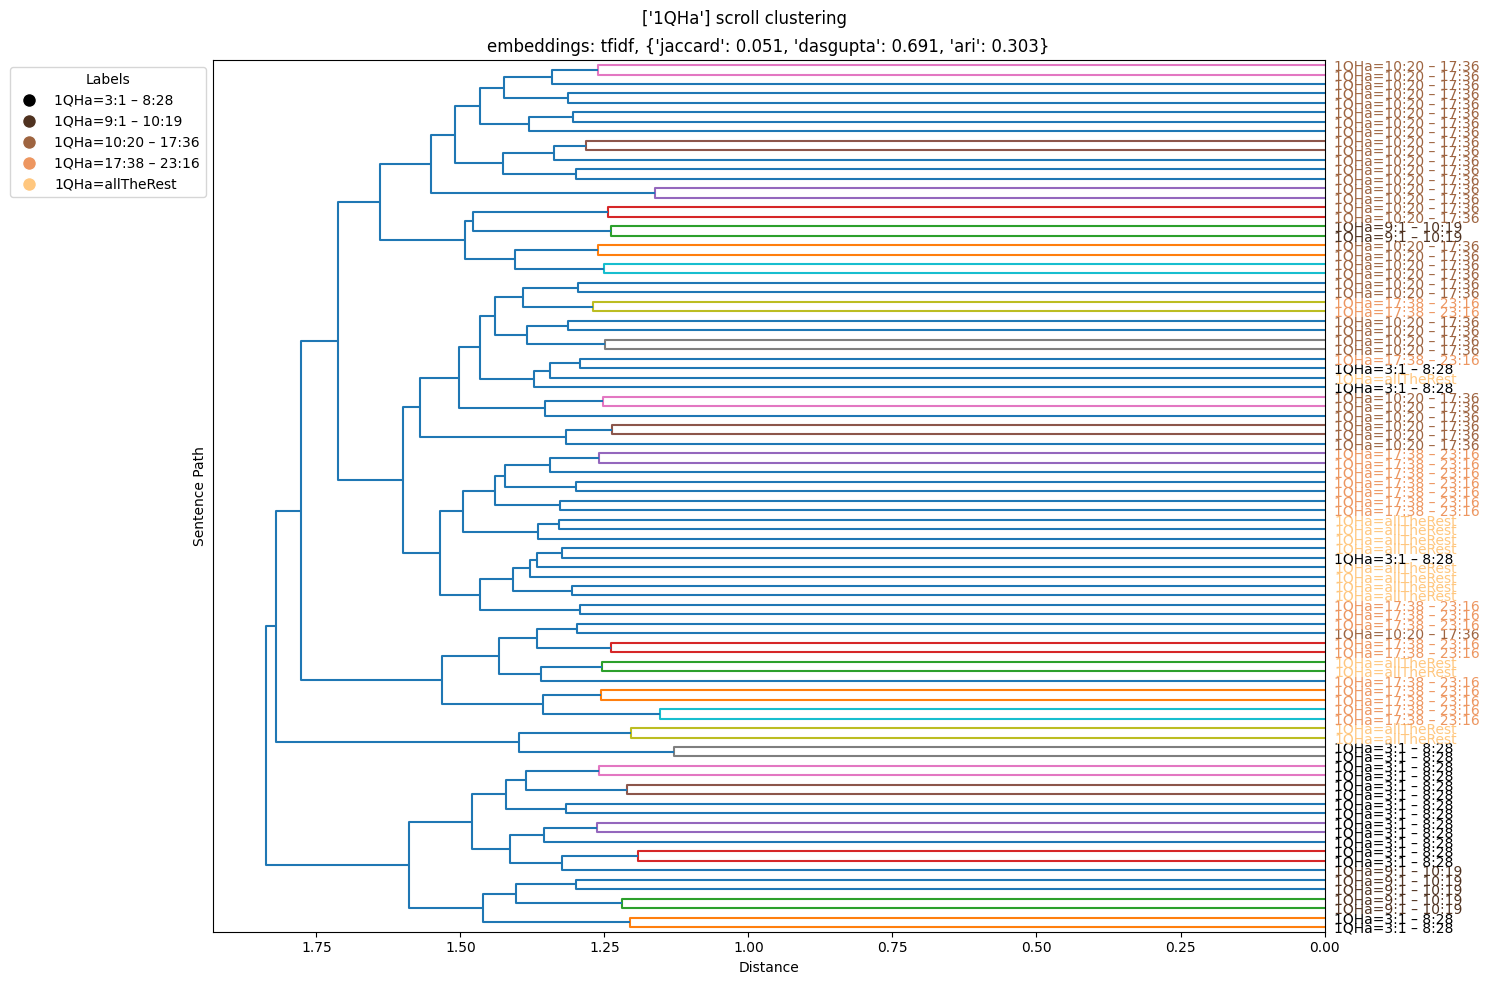

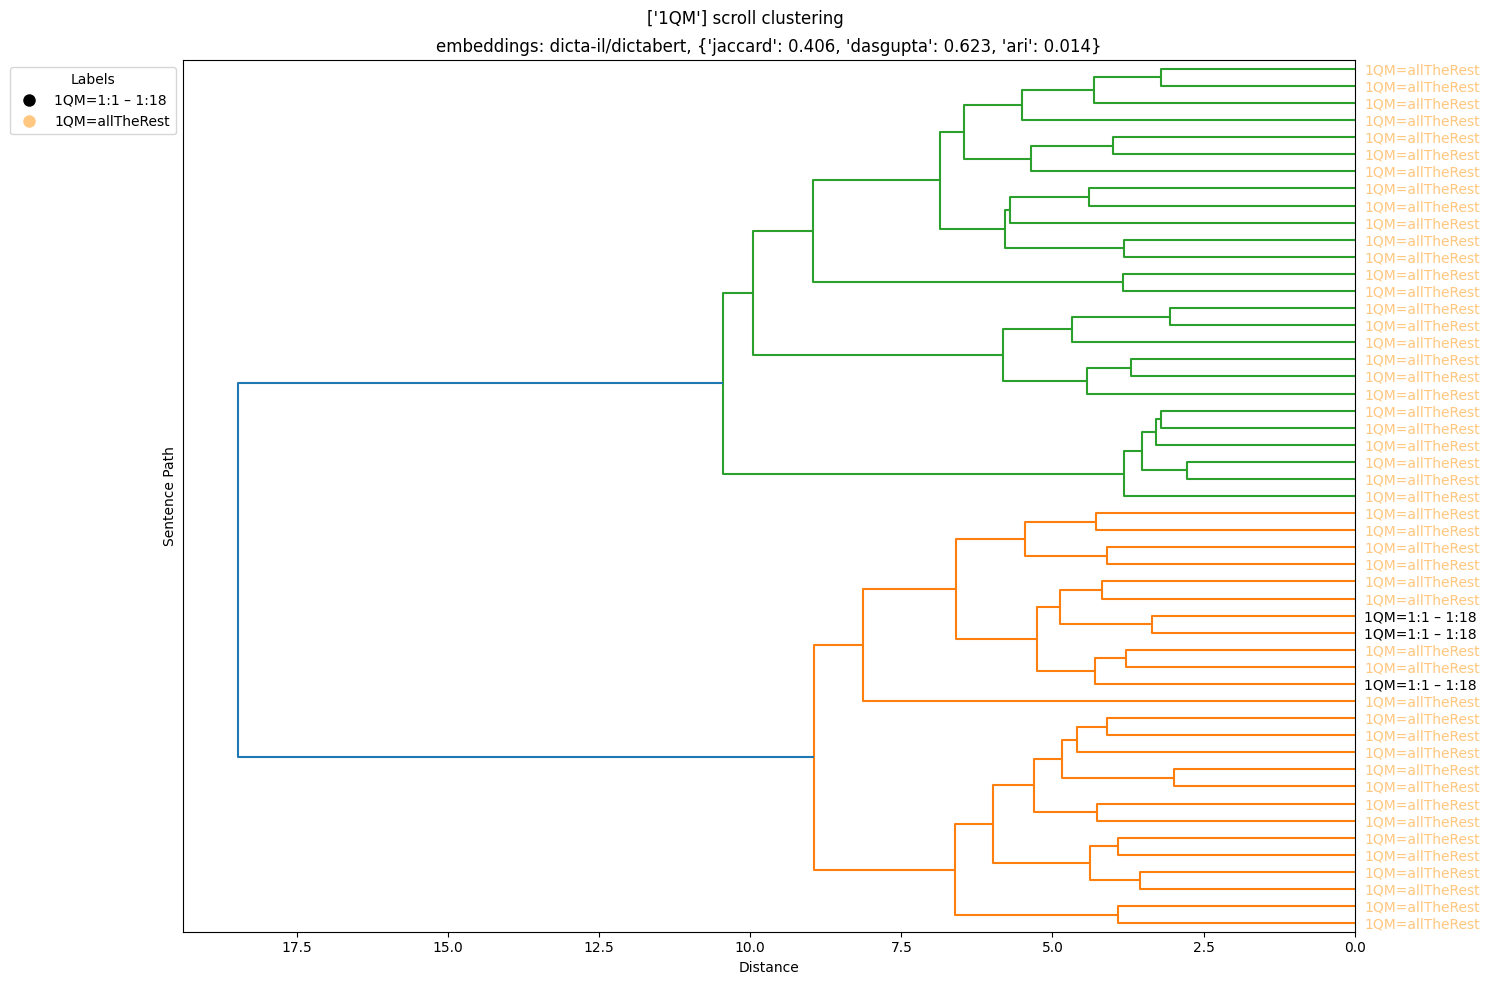

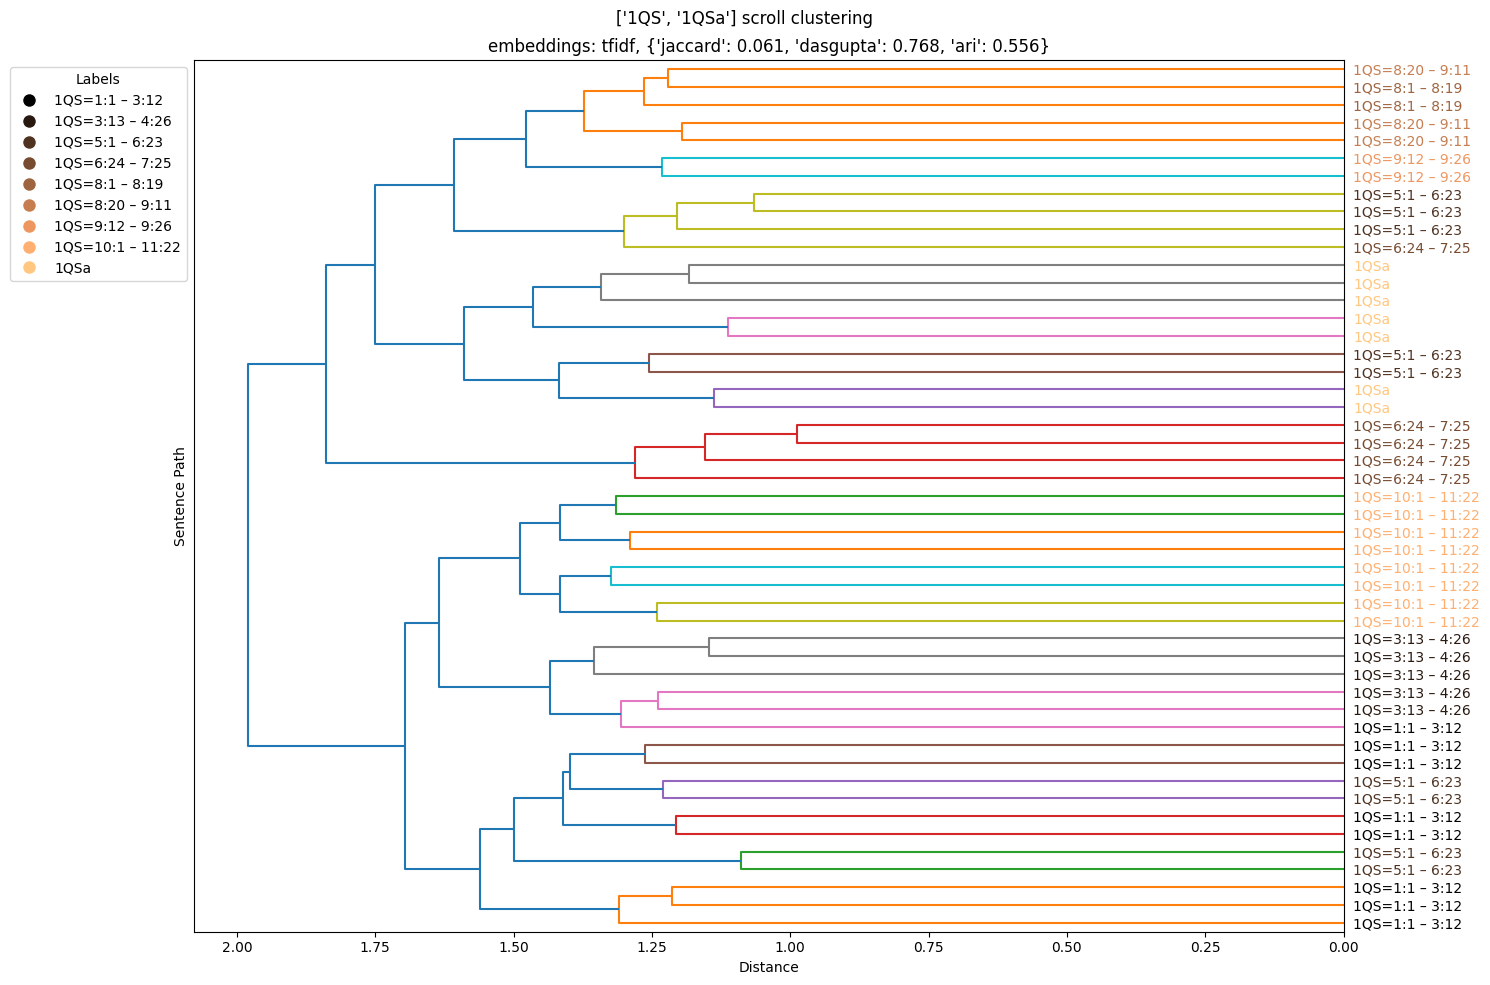

In [12]:
labels_all = {"['1QM']":labels_1QM, "['1QHa']": labels_hodayot, "['1QS', '1QSa']":labels_1QS}
for i, row  in best_ranked.iterrows():
    hirerchial_clustering_by_scroll(df, eval(row['scroll']), labels_all[row['scroll']], row['vectorizer'], processed_vectorizers,adjacency_matrix_all, "label", {"linkage_m":"ward"})

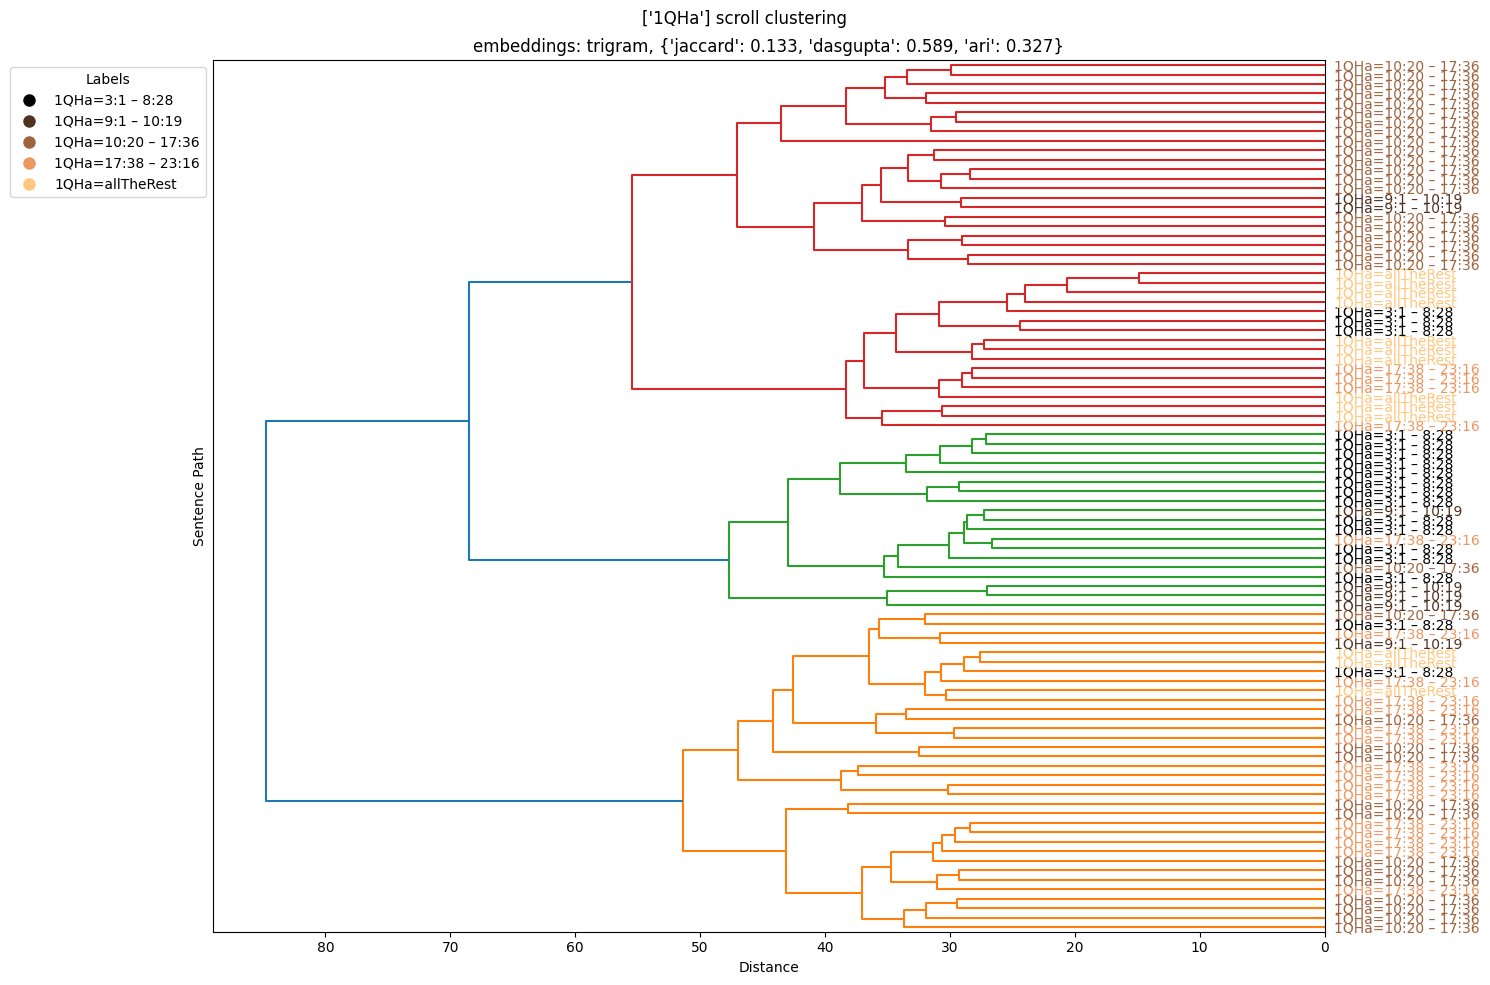

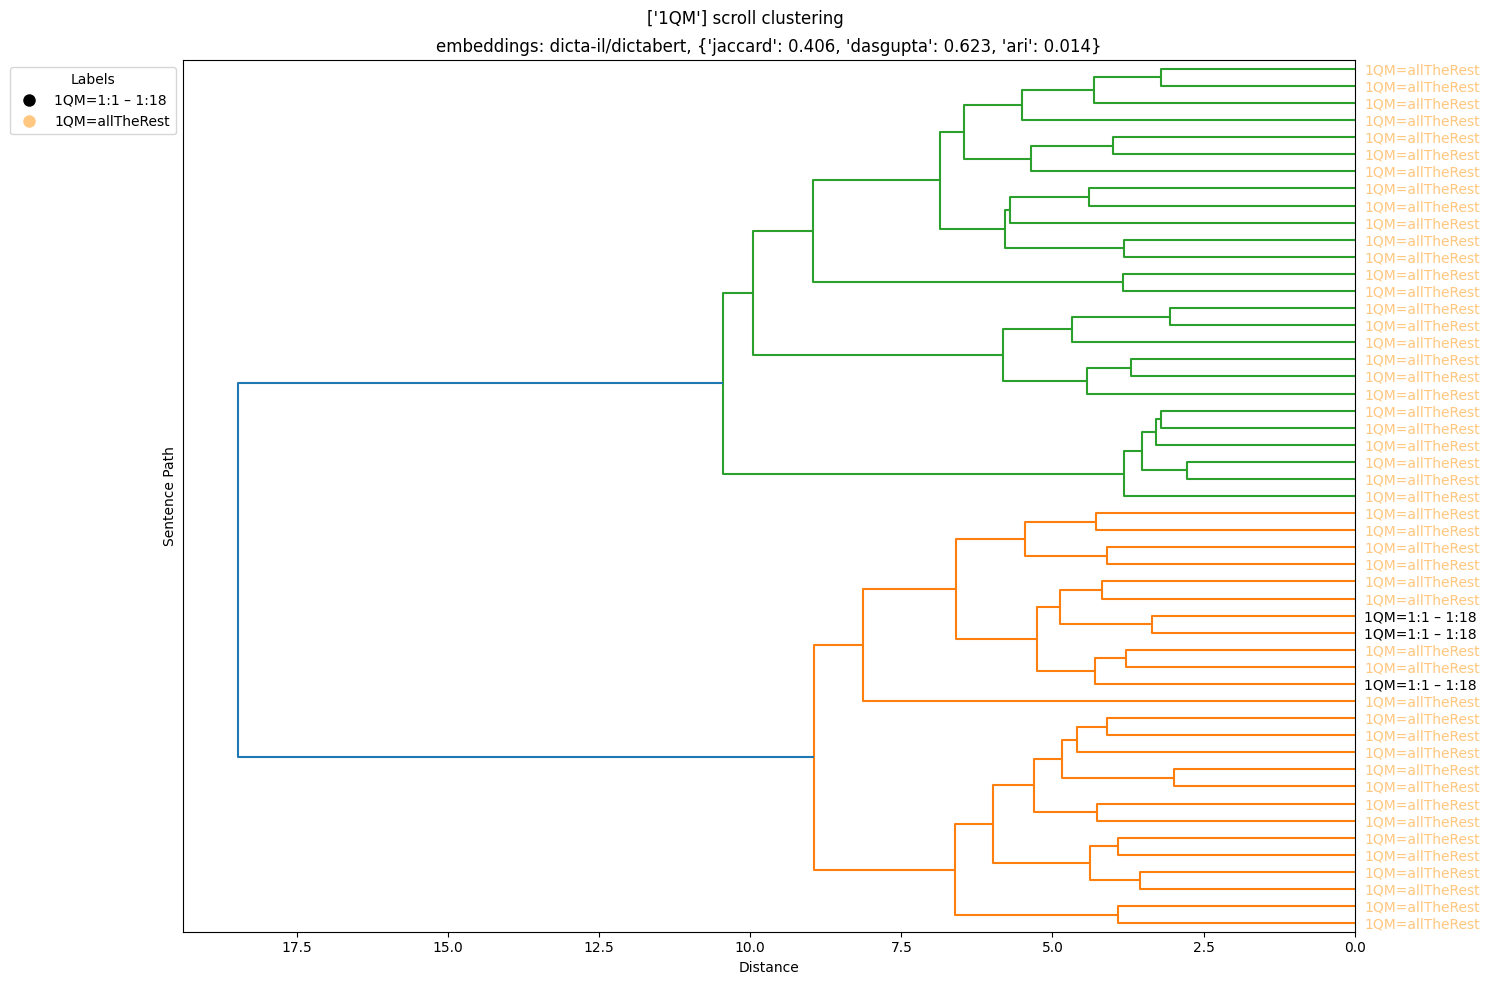

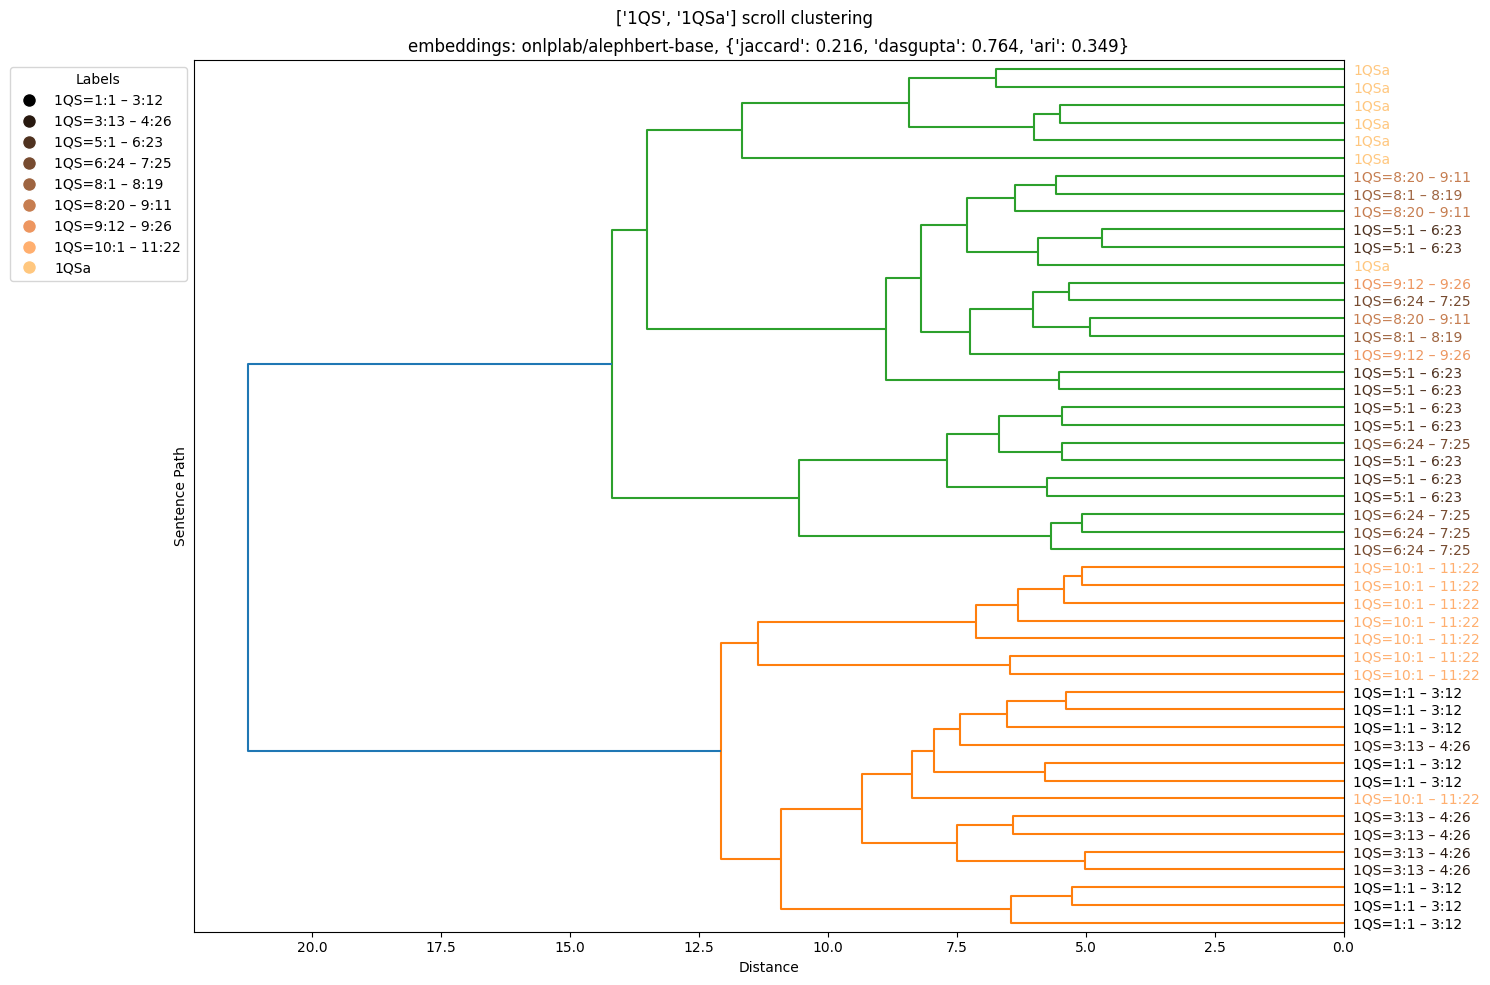

In [13]:
for i, row  in best_normalized.iterrows():
    hirerchial_clustering_by_scroll(df, eval(row['scroll']), labels_all[row['scroll']], row['vectorizer'], processed_vectorizers,adjacency_matrix_all, "label", {"linkage_m":"ward"})